In [1]:
# Import neccessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
# Set a random seed for consistency
def set_seed(seed=123):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

In [3]:
# Load the IMDB dataset 
set_seed(123)
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=10000)

In [4]:
# Preprocess the data
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, seq in enumerate(sequences):
        results[i, seq] = 1.0
    return results

In [5]:
# Vectorize the training and testing data for the model
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [6]:
# Train and Test Split
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

In [7]:
print(len(x_val))
print(len(partial_x_train))
print(len(y_val))
print(len(partial_y_train))

10000
15000
10000
15000


In [8]:
# This is the base function for model
def create_network(layer_count=2, num_units=16, activation_type='relu', dropout_percentage=0.0, loss_function='binary_crossentropy'):
    """
    Builds and compiles a Keras Sequential model with the specified architecture.
    """
    network = keras.Sequential()
    # The closing parenthesis was missing on this line
    network.add(keras.Input(shape=(10000,)))
    
    network.add(layers.Dense(num_units, activation=activation_type))

    for _ in range(layer_count - 1):
        network.add(layers.Dense(num_units, activation=activation_type))
        if dropout_percentage > 0.0:
            network.add(layers.Dropout(dropout_percentage))

    network.add(layers.Dense(1, activation='sigmoid'))

    network.compile(optimizer='rmsprop',
                  loss=loss_function,
                  metrics=['accuracy'])
    return network

In [9]:
# This is the base function for plots
def plot_history(histories, title):
    plt.figure(figsize=(12, 8))

    for label, history in histories.items():
        training_line, = plt.plot(history.history['accuracy'], linestyle='-', label=f'Training - {label}')
        plt.plot(history.history['val_accuracy'], linestyle='--', color=training_line.get_color(), label=f'Validation - {label}')

    plt.title(title, fontsize=16)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.ylim(0.8, 1.01)
    plt.show()
experiment_summary = {}

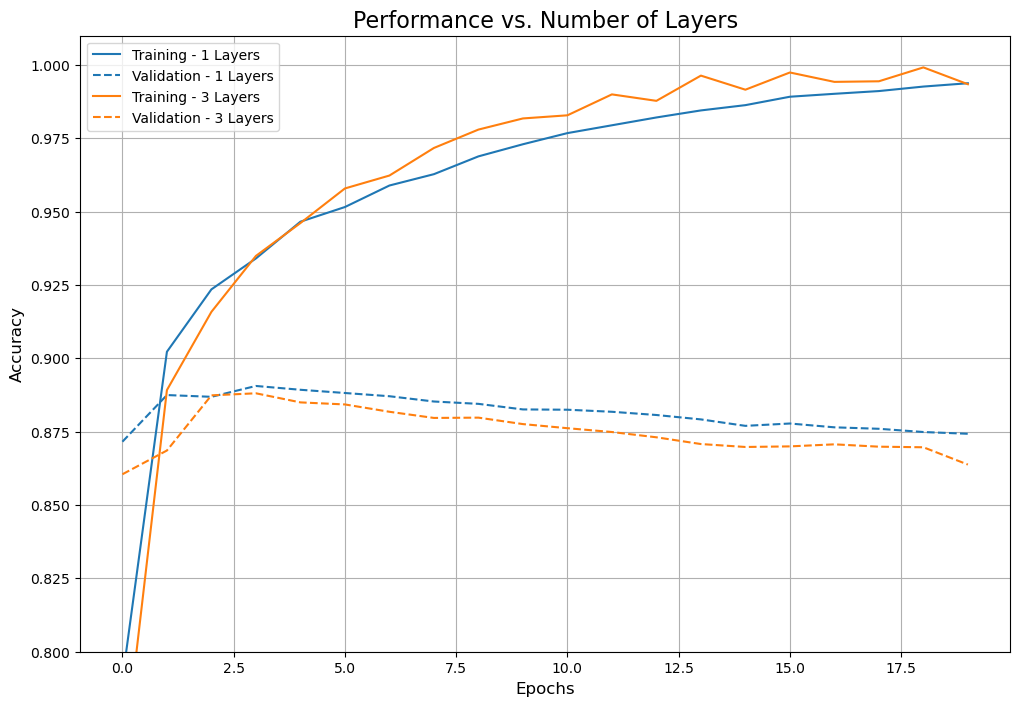

In [10]:
# Test the model with 1 and 3 hidden layers
layer_experiment_histories = {}
for count in [1, 3]:  
    model = create_network(layer_count=count)
    history = model.fit(partial_x_train, partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=0)
    layer_experiment_histories[f'{count} Layers'] = history
    experiment_summary[f'{count} Layers'] = history.history['val_accuracy'][-1]

plot_history(layer_experiment_histories, 'Performance vs. Number of Layers')

Tested using one and three hidden layers against the original two-layer model. The **1-layer model performs better**, showing less overfitting. The 3-layer model's validation accuracy drops significantly after peaking.

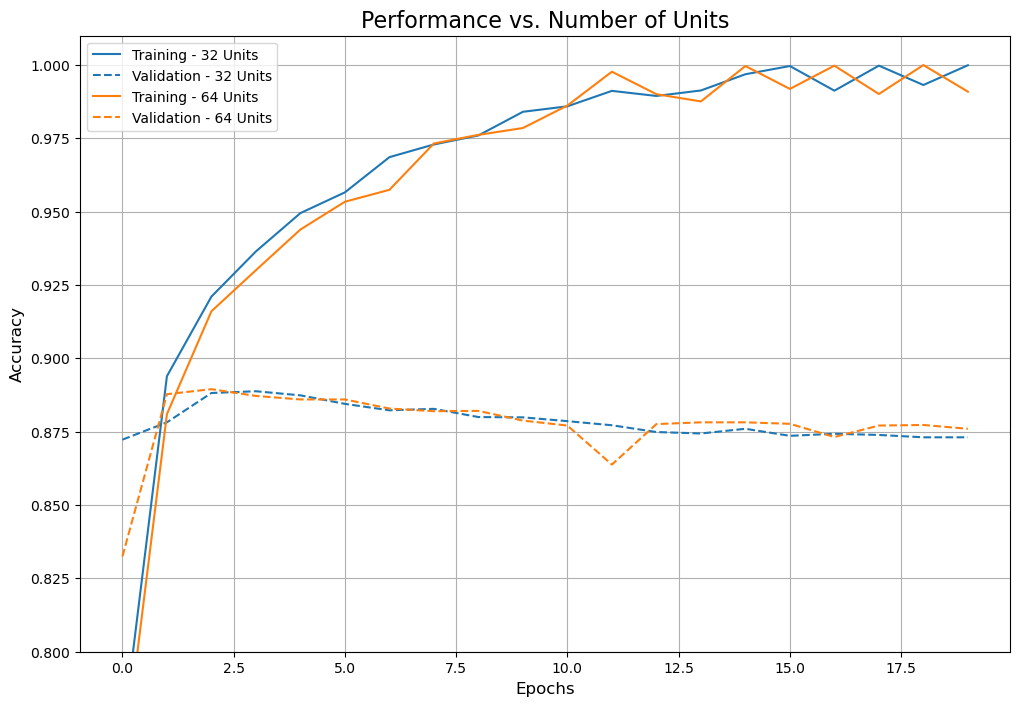

In [11]:
#Test the model with 32 and 64 hidden units per layer
unit_experiment_histories = {}
for unit_count in [32, 64]: 
    model = create_network(num_units=unit_count)
    history = model.fit(partial_x_train,partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=0
                        )
    unit_experiment_histories[f'{unit_count} Units'] = history
    experiment_summary[f'{unit_count} Units'] = history.history['val_accuracy'][-1]

plot_history(unit_experiment_histories, 'Performance vs. Number of Units')


Testes the model using 32 and 64 hidden units.
Increasing hidden units improves performance. The model with **64 units** achieves a **higher peak validation** accuracy than the one with 32 units. 

In [12]:
# Test the model using the Mean Squared Error (mse)
loss_experiment_histories = {}
model_mse = create_network(loss_function='mse')
history_mse = model_mse.fit(partial_x_train, partial_y_train,
                         epochs=20,
                         batch_size=512,
                         validation_data=(x_val, y_val),
                         verbose=0)
loss_experiment_histories['MSE Loss'] = history_mse
experiment_summary['MSE Loss'] = history_mse.history['val_accuracy'][-1]



In [13]:
# Test the model using the Tanh activation function
activation_experiment_histories = {}
model_tanh = create_network(activation_type='tanh')
history_tanh = model_tanh.fit(partial_x_train, partial_y_train,
                           epochs=20,
                           batch_size=512,
                           validation_data=(x_val, y_val),
                           verbose=0)
activation_experiment_histories['Tanh Activation'] = history_tanh
experiment_summary['Tanh Activation'] = history_tanh.history['val_accuracy'][-1]



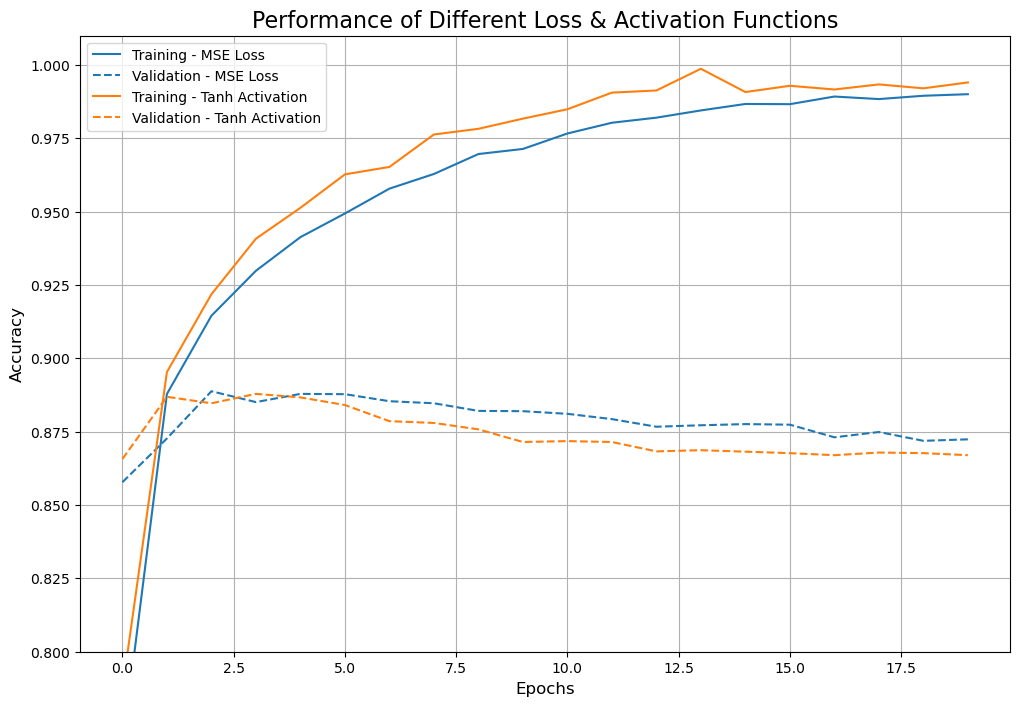

In [14]:
mse_tanh = {
    'MSE Loss': loss_experiment_histories['MSE Loss'],
    'Tanh Activation': activation_experiment_histories['Tanh Activation']
}
plot_history(mse_tanh, 'Performance of Different Loss & Activation Functions')

Tested the model using MSE loss function and tanh activation function instead of Binary_crossentropy and relu.
Using **MSE loss** results in lower validation accuracy. The **Tanh activation** also slightly underperforms, confirming the **original choices were optimal** 

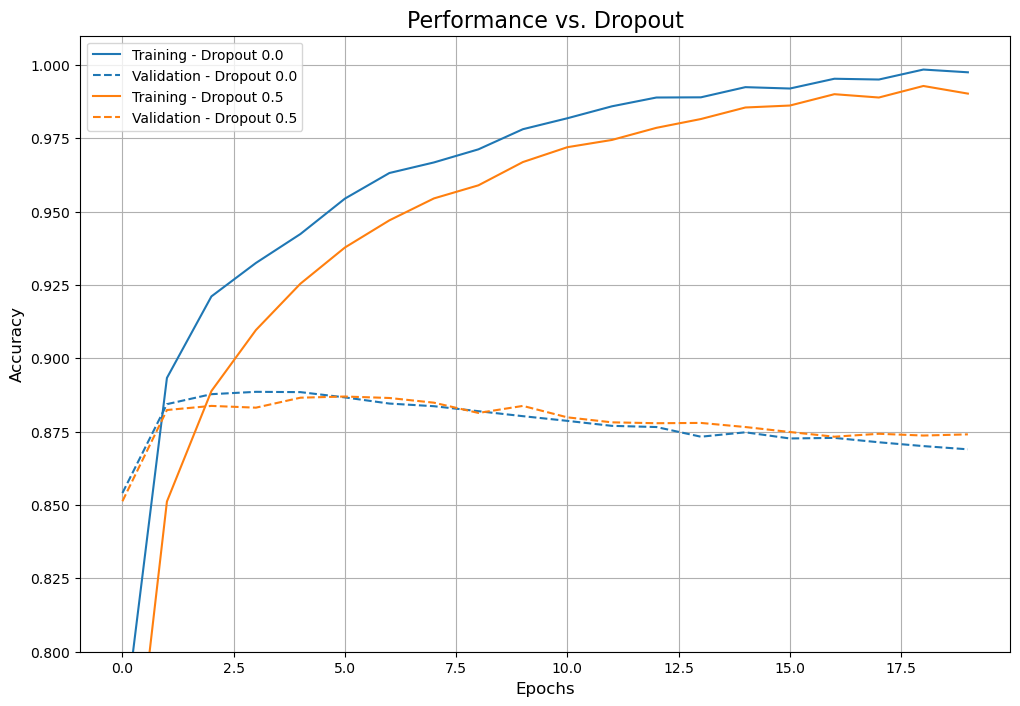

In [15]:
#Test the model with a dropout rate of 0.0 and 0.5 
dropout_experiment_histories = {}
for drop_rate in [0.0, 0.5]:
    model = create_network(dropout_percentage=drop_rate)
    history = model.fit(partial_x_train, partial_y_train,
                        epochs=20,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=0)
    dropout_experiment_histories[f'Dropout {drop_rate}'] = history
    experiment_summary[f'Dropout {drop_rate}'] = history.history['val_accuracy'][-1]

plot_history(dropout_experiment_histories, 'Performance vs. Dropout')

Tested the model with 0.0 and 0.5 dropout rate
With **0.0 dropout**, the model overfit quickly, while 0.5 dropout gave more stable validation accuracy.  

In [16]:
### Create Summary Table
summary_df = pd.DataFrame(list(experiment_summary.items()), columns=['Experiment', 'Final Validation Accuracy'])

print("--- Summary of Experimental Results ---")
print(summary_df.sort_values(by='Final Validation Accuracy', ascending=False))

--- Summary of Experimental Results ---
        Experiment  Final Validation Accuracy
3         64 Units                     0.8760
0         1 Layers                     0.8743
7      Dropout 0.5                     0.8741
2         32 Units                     0.8731
4         MSE Loss                     0.8724
6      Dropout 0.0                     0.8690
5  Tanh Activation                     0.8670
1         3 Layers                     0.8638


In [17]:
final_model = create_network(num_units=64)
final_model.fit(x_train, y_train, epochs=20, batch_size=512, verbose=0)
results = final_model.evaluate(x_test, y_test)

print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8659 - loss: 0.6885
Test Loss: 0.6820
Test Accuracy: 0.8666


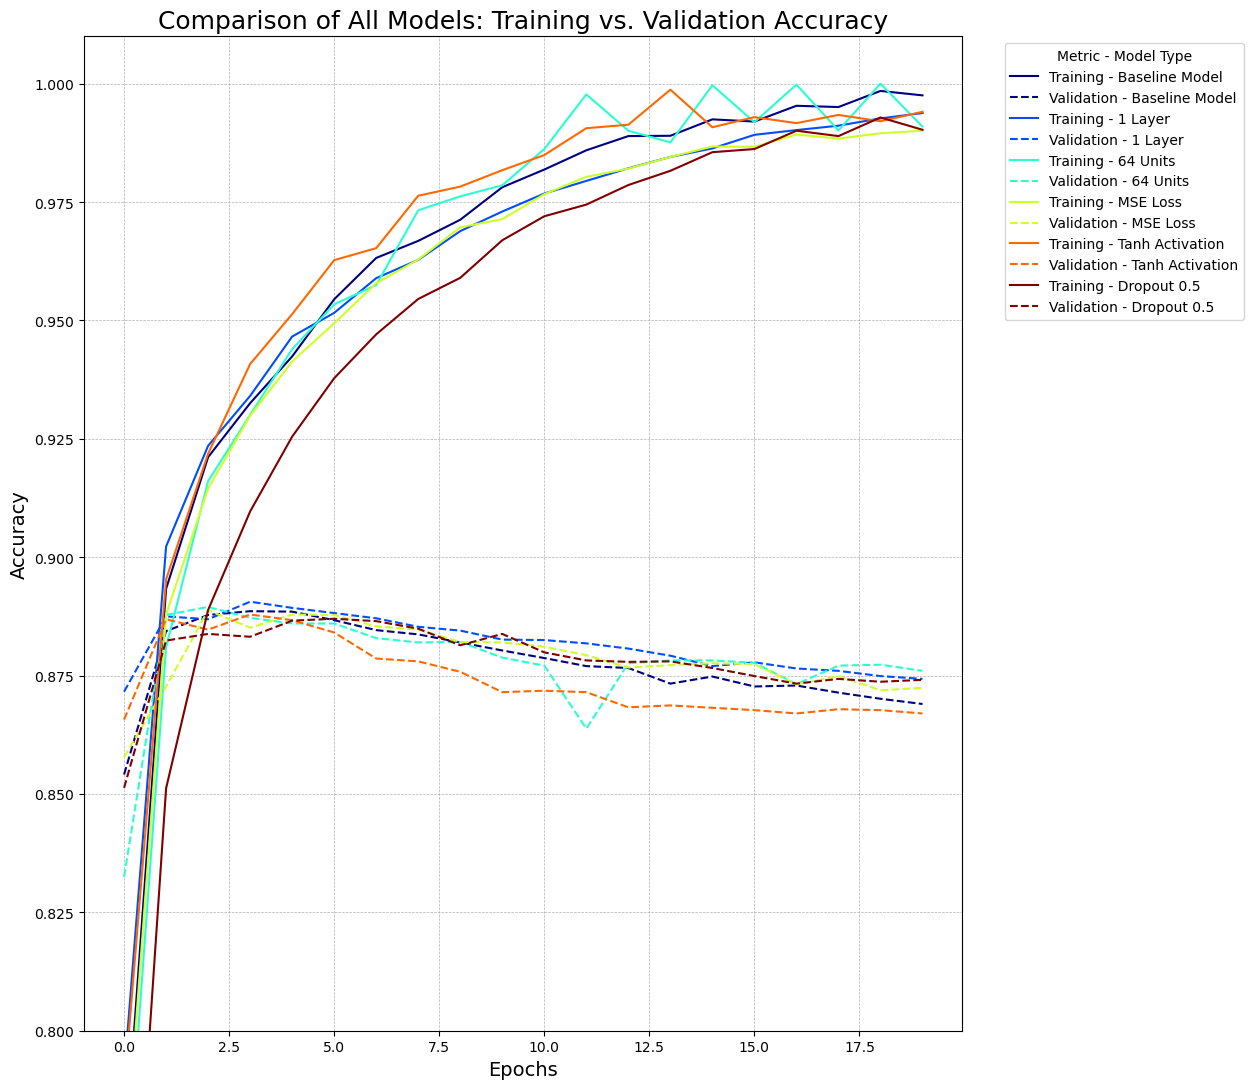

In [18]:
#Final Summary Plot
best_model_histories = {
    'Baseline Model': dropout_experiment_histories['Dropout 0.0'],
    '1 Layer': layer_experiment_histories['1 Layers'],          
    '64 Units': unit_experiment_histories['64 Units'],
    'MSE Loss': loss_experiment_histories['MSE Loss'],        
    'Tanh Activation': activation_experiment_histories['Tanh Activation'], 
    'Dropout 0.5': dropout_experiment_histories['Dropout 0.5']
}


def plot_summary(histories, title):
    plt.figure(figsize=(15, 11))
    colors = plt.cm.jet(np.linspace(0, 1, len(histories)))
    for i, (name, history) in enumerate(histories.items()):
        plt.plot(history.history['accuracy'], color=colors[i], linestyle='-',
                 label=f'Training - {name}')
        plt.plot(history.history['val_accuracy'], color=colors[i], linestyle='--',
                 label=f'Validation - {name}')

    plt.title(title, fontsize=18)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(title="Metric - Model Type", bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(0.80, 1.01) 
    plt.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.show()

plot_summary(best_model_histories, 'Comparison of All Models: Training vs. Validation Accuracy')

This plot shows the **64 Units model achieved the highest validation accuracy** of approximately 88%. However, the **Dropout 0.5 model  was most robust**, stabilizing at 87.5% and preventing overfitting